In [ ]:
!pip install imbalanced-learn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
import sklearn.metrics as metrics
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import precision_score

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import VotingClassifier

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTENC

import time
import warnings
warnings.filterwarnings('ignore')

<b> In this first section of our Jupyter Notebook, we will present the last model used and the steps taken to prepare the train data and test data to be applied to the model used to get the score submited on Kaggle.

In [2]:
#importing our two data sets (data: train set, test_data: test set)
data = pd.read_excel("Train.xlsx")
test_data = pd.read_excel("Test.xlsx")

#set the index as the CITIZEN_ID
data.set_index("CITIZEN_ID", drop = True, inplace=True)
test_data.set_index("CITIZEN_ID", drop = True, inplace=True)

#slipiting the train set in target (equivalent to y_train) and data (equivalent to X_train)
target = data.iloc[:,-1]
data = data.iloc[:, :-1]

In [3]:
#getting to know our data
data.head()

,Name,Birthday,Native Continent,Marital Status,Lives with,Base Area,Education Level,Years of Education,Employment Sector,Role,Working Hours per week,Money Received,Ticket Price
CITIZEN_ID,,,,,,,,,,,,,
12486,Mr. Adam Glover,"July 1,2003",Europe,Married,Wife,Northbury,High School + PostGraduation,13,Private Sector - Services,Repair & constructions,40,0,2273
12487,Mr. Cameron McDonald,"January 25,2006",Europe,Married,Wife,Northbury,Professional School,12,Public Sector - Others,Repair & constructions,40,0,0
12488,Mr. Keith Davidson,"May 10,2009",Europe,Married,Wife,Northbury,Professional School,12,Private Sector - Services,Sales,46,0,2321
12489,Mr. Alexander Gill,"March 25,1985",Europe,Married,Wife,Northbury,High School - 2nd Cycle,11,Private Sector - Services,Security,37,5395,0
12490,Mr. Neil Piper,"May 29,2015",Europe,Single,Other Family,Northbury,PhD,21,Self-Employed (Individual),Professor,45,0,0


In [4]:
#getting to know our variables
#Obsviously, we did use other techinques to get to know our variables, like value counts, but given the goal of this project, it don't make sense to be presenting all those cells, as the conclusions were what lead us to do the steps below
data.describe()

,Years of Education,Working Hours per week,Money Received,Ticket Price
count,22400.000000,22400.000000,22400.000000,22400.000000
mean,13.173884,40.483795,1324.915357,109.145313
std,2.512451,12.370921,9227.771813,500.208904
min,2.000000,1.000000,0.000000,0.000000
25%,12.000000,40.000000,0.000000,0.000000
50%,13.000000,40.000000,0.000000,0.000000
75%,15.000000,45.000000,0.000000,0.000000
max,21.000000,99.000000,122999.000000,5358.000000


In [5]:
#replacing the values with "?" by NaN, so we can deal with them later
data = data.apply(lambda x: np.where(x=="?", None, x))
test_data = test_data.apply(lambda x: np.where(x=="?", None, x))

#using the variable Name to extract the Gender (based on the title of the person), and then dropping the variable Name (all usefull information has been extracted)
data["Gender"] =data["Name"].apply(lambda x: x.split(" ")[0]).apply(lambda x: "M" if x=="Mr." else "F")
test_data["Gender"] =test_data["Name"].apply(lambda x: x.split(" ")[0]).apply(lambda x: "M" if x=="Mr." else "F")
data.drop("Name", axis=1, inplace=True)
test_data.drop("Name", axis=1, inplace=True)

#using the variable Birthday to extract the Age and then dropping the variable Birthday (all usefull information has been extracted)
data["Age"] = data["Birthday"].apply(lambda x: 2048 - int(x[-4:]))
data.drop("Birthday", axis=1, inplace=True)
test_data["Age"] = test_data["Birthday"].apply(lambda x: 2048 - int(x[-4:]))
test_data.drop("Birthday", axis=1, inplace=True)

#fixing our data: people unemployed and that never worked cannot have a number of working hours higher than 0
#Note: this will not mean data leakage (we are fixing inconsistencies), that we can always fix before predicting each entry in the test set, so we are not fixing "unseen data"
data.loc[(data[(data["Employment Sector"] == "Unemployed") | (data["Employment Sector"] == "Never Worked")]).index, ["Working Hours per week"]] = 0
test_data.loc[(test_data[(test_data["Employment Sector"] == "Unemployed") | (test_data["Employment Sector"] == "Never Worked")]).index, ["Working Hours per week"]] = 0

In [6]:
#Here, we separate the PostGraduation and create a new column for it, as a dummy variable (e.g. if someone previously was "Professional School + PostGraduation", now in "Education Level" he has only "Professional School" (as Postgraduation is not a standard education level), but has a 1 in the column "PostGraduation", meaning that while only having Professional School as Education Level, has also a PostGradution).
#Note this separation is necessary as PostGraduation is not a formal level of education (don't follow a order, this is, can be taken after High School or Bachelors or even Master), and therefore by doing this we are better isolating the effect of the PostGraduation
#We will not use a ordinal scale for education as it is hard to classify which is first/last in the case of High School and Profession School

def post_graduation(dataset):
    '''This function's job is to make the split between Level Education and PostGraduation'''
    
    #creating 2 lists, to store both the PostGraduation column and the Education Level, once they're both separated
    post_grad=[]
    educ_level=[]
    
    #Going through each entry in Education Level, splitting it by the " + "
    for row in dataset["Education Level"].apply(lambda x: x.split(" + ")):
        
        #To find the entries in each the split was made and there was "Post" after the " + "
        if "Post" in row[-1]:
            #We will translate the fact of having a PostGraduation in a 1, appending this information to our previously created list
            post_grad.append(1)
            #Storing the eduaction level without the "PostGraduation" in our previously created list "educ_level"
            educ_level.append(row[0])
    
        else:
            #We will translate the fact of not having a PostGraduation in a 0, appending this information to our previously created list
            post_grad.append(0)
            #Storing the eduaction level without the "PostGraduation" in our previously created list "educ_level"
            educ_level.append(row[0])
    
    #Transforming our lists into series, giving them the correct index (the Citizens' ID), and substituting them in our dataframe, in the respective place. 
    #Note: in the case of High School, we added the word "Complete", so it was in line with what the other entries had.
    dataset["PostGraduation"] = pd.Series(post_grad, index=dataset.index)
    dataset["Education Level"] = pd.Series(educ_level, index=dataset.index).apply(lambda x: np.where(x=="High School", "High School Complete", x))
        
    return dataset

#applying this function to both data and test_data
data = post_graduation(data)
test_data = post_graduation(test_data)

In [7]:
#We also decided to split the Marital Status, from conditions of spouses (missing or in the army). As we belive this will make the dataset more easy to interpret, and at same time better isolate the different effect

def spouse_status(dataset):
    '''This function's job is to make the split between Marital Status and the spouse situation (missing or in the army)'''
    
    #Creating 2 lists to store both the Spouse Missing and the Spouse in the Army, once these series are created
    spouse_missing=[]
    spouse_army=[]

    #Going through each entry in Marital Status and splitting it by the " - "
    for row in dataset["Marital Status"].apply(lambda x: x.split(" - ")):
        
        #If there's a "Missing" in the entry, we will add a 1 in the correspondent list, otherwise, a 0 will be added
        if "Missing" in row[-1]:
            spouse_missing.append(1)
        else:
            spouse_missing.append(0)
        
        #Repeating the process, but with the word "Army"
        if "Army" in row[-1]:
            spouse_army.append(1)
        else:
            spouse_army.append(0)
    
    #Converting both lists to series, assigning the Citizens' ID as index, and creating these two columns in our dataset
    dataset["Spouse Missing"]=pd.Series(spouse_missing, index=dataset.index)
    dataset["Spouse in the Army"]=pd.Series(spouse_army, index=dataset.index)
    
    #Transforming all entries with "Married - Spouse Missing" and "Married - Spouse in the Army" into just "Married"
    dataset["Marital Status"]=dataset["Marital Status"].apply(lambda x: np.where((x=="Married - Spouse Missing") or (x=="Married - Spouse in the Army"), "Married", x))   
    
    return dataset

#Applying the function spouse_status to both data and test_data
data = spouse_status(data)
test_data = spouse_status(test_data)

In [8]:
#fixing the datatype of the incorrectly typed variables 
data[["Years of Education", 'Working Hours per week', 'Money Received', 'Ticket Price']] = data[["Years of Education", 'Working Hours per week', 'Money Received', 'Ticket Price']].astype(int)
test_data[["Years of Education", 'Working Hours per week', 'Money Received', 'Ticket Price']] =test_data[["Years of Education", 'Working Hours per week', 'Money Received', 'Ticket Price']].astype(int)

#storing the columns names of the numeric and categorical variables
numeric_features=["Age",'Years of Education','Working Hours per week', 'Money Received', 'Ticket Price']
categorical_features=['Gender', "Spouse Missing","Marital Status",'Native Continent', 'Spouse in the Army','Lives with', 'Base Area', 'Education Level',"PostGraduation",'Employment Sector', 'Role']

In [9]:
def mutual_information (dataset, categorical_features, level):
    '''This function returns the columns in our Dataset that have a higher normalized mutal information between themselves than a givel level. This is, the columns with categorical variables that are redundant.For each pair of variables, we will only return one, so we don't delete both.'''
    
    #Creating a list to store the columns' names to return in the end
    columns=[]
    
    #Creating an auxiliary list to help us in the process of interating through variables
    already_used=[]
    
    #Interating through each categorical feature
    for variable in dataset[categorical_features].columns.values:
        
        #Creating a list with all the other categorical features besides the one we are interating now and the ones we already did so (stored meanwhile in our auxiliary list) 
        remaining_variables=[column_name for column_name in dataset[categorical_features].columns.values if ((column_name!=variable) and (column_name not in already_used)) ]
        
        #Going over each varaible in the remaing_variables list
        for other_var in remaining_variables: 
            
            #Computing the Normalized Mutual Information between our variable and the one in the remaining_variables, and appending the variable's name if the result is higher than the given level.
            #Note: We use break, because once a variable is appended, there's no point in continuing to access it with the variables that remain
            if normalized_mutual_info_score(dataset[variable], dataset[other_var]) > level:
                columns.append(variable)
                break
        #Registing which variables we already interated over.
        already_used.append(variable)
    
    return columns


def too_strong_corr(data, level):
    '''This function returns the columns in our Dataset that have on absolute terms a higher correlation between themselves than a given level. This is, the columns with numeric variables that are redundant. For each pair of variables, we will only return one, so we don't delete both.'''
    
    #Creating a list to append the variables' names to return in the end
    columns = []
    
    #Getting the correlations between the features given in the dataset 'data' (we use abs as we want all high values in absolute terms, and the np.where to get only a part of the matrix, as it is symetric and we also don't want the main diagonal (to this we create a mask with np.triu with k=1 to only get the first half of the matrix withouth the diagonal, and the np.ones and the np.bool to "formalize the mask used")
    correlations = data.corr().abs().where(np.triu(np.ones(data.corr().abs().shape), k=1).astype(np.bool)).unstack()
 
    #Going over each pair of variables and the respective correlation
    for row in correlations.iteritems():
        
        #If the correlation is higher than the given level, and neither one of the variables' names is in the list columns yet, we append the name of the first feature to it (we have to check this, to not be removing variables because they are correlated with variables already excluded).
        if row[1]>level:
            if ((row[0][0]  not in columns) & (row[0][1]  not in columns)) :
                columns.append(row[0][0])

    return columns

In [10]:
#Defining the model we want to use.
model =  GradientBoostingClassifier(n_estimators=1150, max_features=0.35, min_samples_leaf=2, random_state= 42)

#Dealing with outliers (we decided to not use formal methods like IQR, as those would make us loose big chunks of our data, taking representativeness from it)
#Based on this, we defined what we think are natural thresholds for Age, Working Hours and Years of Education, while looking at our data (and boxplots, see Plot_1 below) to find the acceptables intervals for Money received and Ticked Price
data = data[(data["Age"]>=17) & (data["Age"]<=90) & (data["Working Hours per week"]>=0) & (data["Working Hours per week"]<=80) & (data["Ticket Price"]<=30000) & (data["Money Received"]<=400000) & (data["Years of Education"]<=21) & (data["Years of Education"]>=2)]
target = target.loc[data.index.values] 

#Handling the NaN in training set based on the mode of each column
data["Employment Sector"] = data["Employment Sector"].fillna(data["Employment Sector"].mode()[0])
data["Role"] = data["Role"].fillna(data["Role"].mode()[0])
data["Base Area"] = data["Base Area"].fillna(data["Base Area"].mode()[0])

#Handling the NaN in training set based on the mode of each column of the train set (to avoid data leakage)
test_data["Employment Sector"] = test_data["Employment Sector"].fillna(data["Employment Sector"].mode()[0])
test_data["Role"] = test_data["Role"].fillna(data["Role"].mode()[0])
test_data["Base Area"] = test_data["Base Area"].fillna(data["Base Area"].mode()[0])

#create a new dataframe with all possible categorical variables labels, and fitting a OneHotEncoder to it
#Note: this will not lead to data leakage, as we are just making sure we will create the right amount of columns in both datasets
X_dummy_model = pd.concat([test_data, data])
encoder = OneHotEncoder(sparse=False, drop="first")
encoder.fit(X_dummy_model[categorical_features])

#applying the encoder to the train data set
x = encoder.transform(data[categorical_features])
x = pd.DataFrame(x, index=data.index, columns = encoder.get_feature_names(categorical_features))
data = pd.concat([data.drop(columns =categorical_features),x], axis=1)

#applying the encoder to the test data set
x = encoder.transform(test_data[categorical_features])
x = pd.DataFrame(x, index=test_data.index, columns = encoder.get_feature_names(categorical_features))
test_data = pd.concat([test_data.drop(columns =categorical_features),x], axis=1) 

#Counting how long the model takes to fit, while fitting the model to our data
begin = time.perf_counter()
model.fit(data, target)
end = time.perf_counter()

#computing the f1_score for the training dataset
value_train = f1_score(target, model.predict(data), average="micro")

#applying our model to the test dataset to predict the target in the test dataset
test_data_target = model.predict(test_data)

In [11]:
print("The F1 score obtained in the train set was,", value_train, ". While the model took", round(end-begin,3), " seconds to run.")

The F1 score obtained in the train set was, 0.8922295627162824 . While the model took 15.107  seconds to run.


In [12]:
#confusion_matrix(target, model.predict(data))

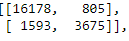

In [ ]:
# #Getting the feature importance of our model

# plt.figure(figsize=(12,8))

# #Getting the feature importance values according with our model, and converting it into a dataframe
# feature_importance=pd.DataFrame(model.feature_importances_, columns=["Importance"])

# #Creating a new column which has the variables' names associated with the scores previously gotten
# feature_importance["Feature Name"]=data.columns

# #Sorting our values so we are able to select the first X variables more important
# feature_importance.sort_values(by="Importance", ascending = False, inplace = True)

# #Plotting the 10 most important features to our model
# plt.title("Feature Importance", y=1.005)
# sns.barplot(y='Feature Name', x='Importance', data=feature_importance[:10], color = "grey")
# plt.show()

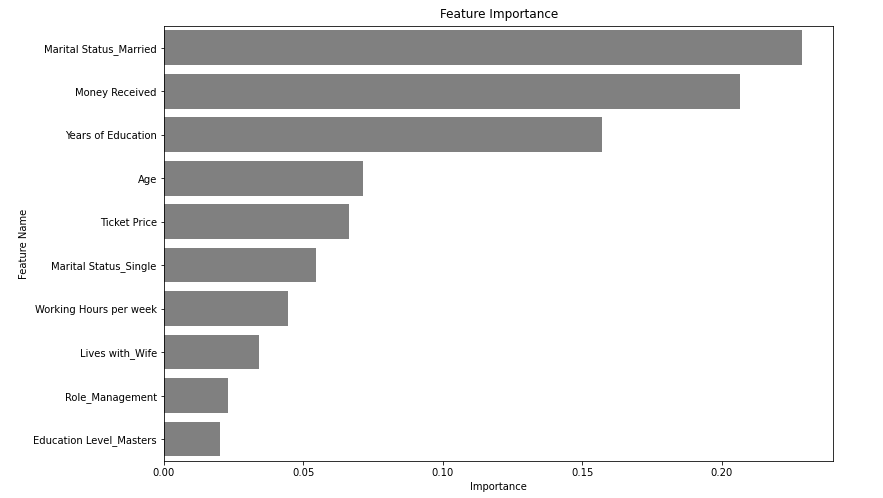

In [ ]:
# #Plotting our ROC curve

# #Getting our FPR and TPR values 
# fpr, tpr, threshold = metrics.roc_curve(target, model.predict_proba(data)[:,1])
# roc_auc = metrics.auc(fpr, tpr)

# #Plotting our curve, legending, defining the range of the axis, and giving a title to the graph
# plt.title('ROC CURVE')
# plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
# plt.legend(loc = 'lower right')
# plt.plot([0, 1], [0, 1])
# plt.ylabel('TPR')
# plt.xlabel('FPR')
# plt.show()

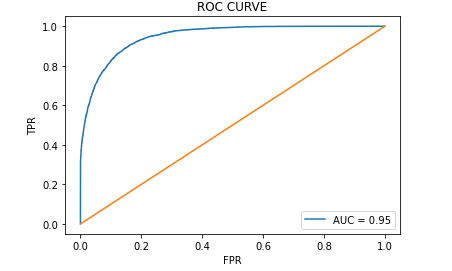

In [ ]:
# #Finding the ratio of ones to zeros in our "target". For that, we create two auxiliary variables, which will "count"  the number of 1's and the number of 0's.
# #In the end, we compute the ratio of 1's to 0's, by dividing the number of 1's by the number of 0's.
# n_1 = 0
# n_0 = 0
# for value in target:
#     if value == 1:
#         n_1+=1
#     else:
#         n_0+=1
# ratio_target=n_1/n_0

# #We repeat the same process, this time for the predictions of our "data".
# n_1=0
# n_0=0
# for value in model.predict(data):
#     if value == 1:
#         n_1+=1
#     else:
#         n_0+=1
# ratio_data_predicted=n_1/n_0

# #Once again, we repeat everything, this time for our variable "test_data_target"
# n_1=0
# n_0=0
# for value in test_data_target:
#     if value == 1:
#         n_1+=1
#     else:
#         n_0+=1
# ratio_test_data_predict=n_1/n_0


# #Plotting the 3 ratios, in order to compare them.
# plt.figure(figsize=(8,5))
# plt.title("Ratio of 1's to 0's")
# ratios=pd.DataFrame([ratio_target,ratio_data_predicted,ratio_test_data_predict], index=["Train Ground Truth", "Train Predicted", "Test Predicted"], columns=["Ratio"])
# sns.barplot(x=ratios.index, y=ratios["Ratio"], color="grey")
# plt.show()

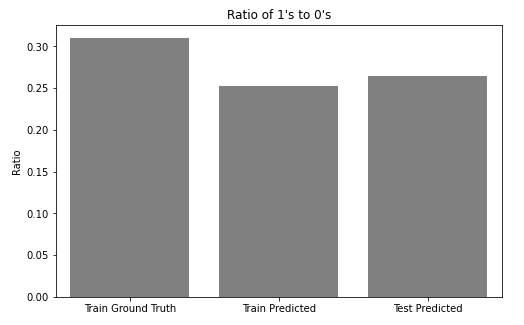

In [13]:
#making test_data_target a Dataframe, with the correct index (ID of the citizen)
test_data_target = pd.DataFrame(data = test_data_target, index = test_data.index, columns = ["Income"])

#outputing to csv our results
test_data_target.to_csv("Group22_Final_Version.csv")

In [ ]:
# #Seeing how many 1's and 0's we have in our variable "test_data_target", which corresponds to our prediction regarding the Test dataset
# test_data_target["Income"].value_counts()

(Plot_1) The following graphs are the result of our final box plots, using the full train data. The same conclusions applied when in a first phase we used train and test split. 

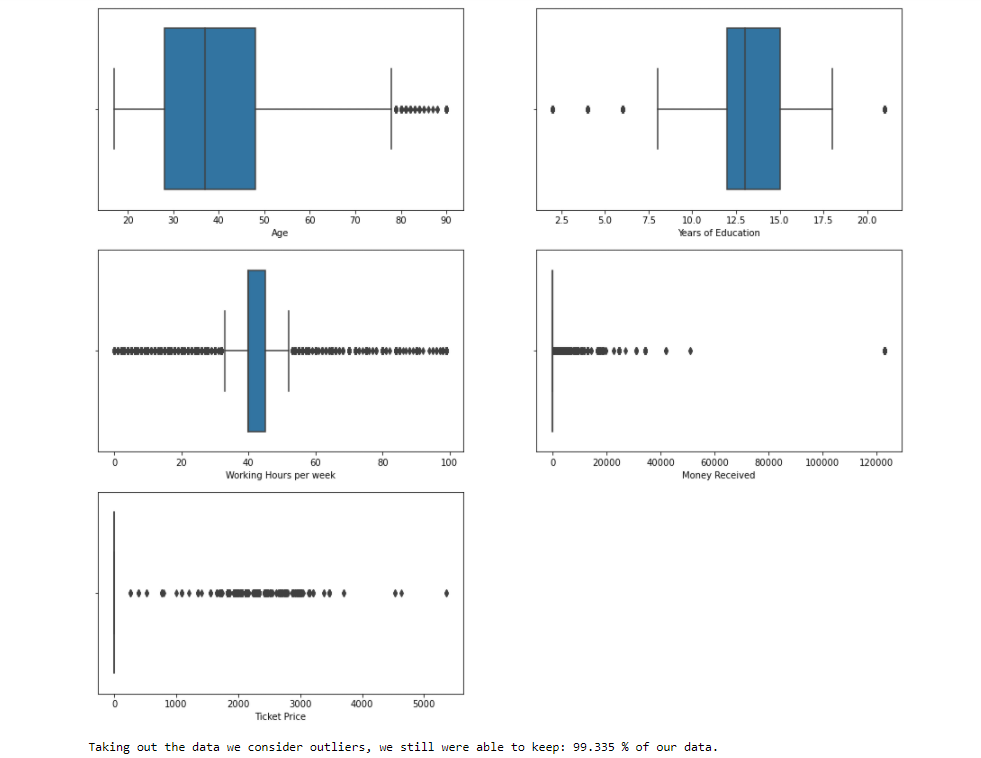

<b> In this next section we will show the steps we took to arrive to our final model. Despite being only asked to present the final model, we think is usefull to present this section, on the steps taken to reach it, and present also slightly some of the tests we also did with other models.

In [ ]:
# ##  We will not comment this code, as it is basically just a copy of the one above. 
# ## Please just make sure you run the functions post_graduation, spouse_status, kendall, mutual_information and too_strong_corr

# data = pd.read_excel("Train.xlsx")
# data.set_index("CITIZEN_ID", drop = True, inplace=True)
# target = data.iloc[:,-1]
# data = data.iloc[:, :-1]
# data = data.apply(lambda x: np.where(x=="?", None, x))
# data["Gender"] =data["Name"].apply(lambda x: x.split(" ")[0]).apply(lambda x: "M" if x=="Mr." else "F")
# data.drop("Name", axis=1, inplace=True)
# data["Age"] = data["Birthday"].apply(lambda x: 2048 - int(x[-4:]))
# data.drop("Birthday", axis=1, inplace=True)
# data.loc[(data[(data["Employment Sector"] == "Unemployed") | (data["Employment Sector"] == "Never Worked")]).index, ["Working Hours per week"]] = 0
# data = post_graduation(data)
# data = spouse_status(data)
# data[["Years of Education", 'Working Hours per week', 'Money Received', 'Ticket Price']] = data[["Years of Education", 'Working Hours per week', 'Money Received', 'Ticket Price']].astype(int)
# numeric_features=["Age",'Years of Education','Working Hours per week', 'Money Received', 'Ticket Price']
# categorical_features=['Gender', "Spouse Missing","Marital Status",'Native Continent', 'Spouse in the Army','Lives with', 'Base Area', 'Education Level',"PostGraduation",'Employment Sector', 'Role']

<b> Firstly we will test some models with their default parameters, and while iterating by different standarization methods and feature selection techiques.

In [ ]:
# def avg_score(scale, estimator, model):
#     '''This function will accept a model, standarization method and a feature selector, and, using a Stratified KFold and some data preparation techniques (including the standarization of data with the method received as input), return the average performance, standard deviation of the model and time the model took to run.'''

#     global data, target, numeric_features, categorical_features
    
#     #Using kfold=10, as empirically, this is the number of folds that usually yields the best results
#     kf = StratifiedKFold(n_splits=10, shuffle= True, random_state=42) 
    
#     #Creating lists to store the results obtained in each fold
#     score_train= []
#     score_test= []
#     timer = []
    
#     #Iterating over each fold
#     for train_index, test_index in kf.split(data, target):
        
#         #Defining our X_train, X_test, y_train and y_test
#         X_train, X_test = data.iloc[train_index], data.iloc[test_index]
#         y_train, y_test = target.iloc[train_index], target.iloc[test_index]
        
#         X_train = X_train[(X_train["Age"]>=17) & (X_train["Age"]<=90) & (X_train["Working Hours per week"]>=0) & (X_train["Working Hours per week"]<=80) & (X_train["Ticket Price"]<=3000) & (X_train["Money Received"]<40000) & (X_train["Years of Education"]<=21) & (X_train["Years of Education"]>=2)]
#         y_train=y_train.loc[X_train.index.values]
        
#         X_train["Employment Sector"] = X_train["Employment Sector"].fillna(X_train["Employment Sector"].mode()[0])
#         X_train["Role"] = X_train["Role"].fillna(X_train["Role"].mode()[0])
#         X_train["Base Area"] = X_train["Base Area"].fillna(X_train["Base Area"].mode()[0])
        
        
#         X_test["Employment Sector"] = X_test["Employment Sector"].fillna(X_train["Employment Sector"].mode()[0])
#         X_test["Role"] = X_test["Role"].fillna(X_train["Role"].mode()[0])
#         X_test["Base Area"] = X_test["Base Area"].fillna(X_train["Base Area"].mode()[0])
        
       
#         #Using the too_strong_corr function (with a threshold of 0.75) to get the redundant numeric features in X_train, in order to drop them in both the X_train and the X_test
#         corr = too_strong_corr(X_train[numeric_features], 0.75)    
#         if len(corr)!=0:
#             X_train.drop(corr, axis=1, inplace=True)
#             X_test.drop(corr, axis=1, inplace=True)
#             for column in corr:
#                 numeric_features.remove(column)

#         #Using the function mutual_information (with a threshold of 0.75), to get the redundant categorical features in X_train, so we can drop them in both the X_train and the X_test
#         mutual = mutual_information(X_train, categorical_features, 0.75)    
#         if len (mutual)!=0:
#             X_train.drop(mutual , axis=1, inplace=True)
#             X_test.drop(mutual, axis=1, inplace=True)
#             for column in mutual:
#                 categorical_features.remove(column)

#         #If the scale method given to the function is "None", this means there is no scale method, and therefore, we will just proceed
#         if scale == "None":
#             scale = "None"

#         #Otherwise, if a scale method is given, we will fit it to the X_train, so then we can transform both the X_train and the X_test, without incurring in data leakage
#         else:
#             scaler = scale.fit(X_train[numeric_features])
#             X_train[numeric_features]=scaler.transform(X_train[numeric_features])
#             X_test[numeric_features]=scaler.transform(X_test[numeric_features])
        
#         X_dummy_model = pd.concat([X_train, X_test])
#         encoder = OneHotEncoder(sparse=False, drop="first")
#         encoder.fit(X_dummy_model[categorical_features])

#         x = encoder.transform(X_train[categorical_features])
#         x = pd.DataFrame(x, index=X_train.index, columns = encoder.get_feature_names(categorical_features))
#         X_train = pd.concat([X_train.drop(columns =categorical_features),x], axis=1)

#         x = encoder.transform(X_test[categorical_features])
#         x = pd.DataFrame(x, index=X_test.index, columns = encoder.get_feature_names(categorical_features))
#         X_test = pd.concat([X_test.drop(columns =categorical_features),x], axis=1) 
        
       
#         #If the estimator passed is regarding Ridge (and the model does not concern the KNN), we will use RidgeClassifier to perform feature selection. 
#         #Note that we fit our selector to the X_train (and y_train), and then we use its results to withdraw the same variables from x_train and X_test
#         if ((estimator== "Ridge Top Features") and (model!=modelKNN) and (model != modelBKNN)):
#             selector = SelectFromModel(estimator = RidgeClassifier(random_state= 42))
#             selector.fit(X_train, y_train)
#             X_train = X_train[X_train.columns[(selector.get_support())]]
#             X_test = X_test[X_test.columns[(selector.get_support())]]
            
#         #If the estimator passed is regarding the Decision Tree (and the model does not concern the KNN), we will use a DecisionTreeClassifier to perform feature selection
#         #Note that we fit our selector to X_train (and y_train) in order to get the features to keep, but then we apply those results to both the X_train and the X_test
#         elif ((estimator == "Decision Tree Top Features") and (model!=modelKNN) and (model != modelBKNN)):
#             selector = SelectFromModel(estimator = DecisionTreeClassifier(random_state = 42))
#             selector.fit(X_train, y_train)
#             X_train = X_train[X_train.columns[(selector.get_support())]]
#             X_test = X_test[X_test.columns[(selector.get_support())]]
           
#         #If the estimator passed is regarding PCA, we will use it to reduce our input space.
#         #Note that here there's no problem if the model passed is the KNN, as both it and PCA only work with numeric features.
#         elif estimator =="PCA":
#             #We will create the PCA instance in order to keep the components necessary to capture 80% of the varaince of our numeric variables
#             pca = PCA(n_components=0.8, random_state=42)
#             #We will fit our 'pca' to the numeric features of our X_train, but then we will transform both our X_train and X_test with those results
#             pca_fitted= pca.fit(X_train[numeric_features])
#             pca_train= pca.transform(X_train[numeric_features])
#             pca_test= pca.transform(X_test[numeric_features])
#             pcas=[]
            
#             #Creating the names of our new variables, in the format "PCA X"
#             for num in range(1,pca.n_components_+1):
#                 pcas.append("PCA "+str(num))
            
#             #Creating a dataframe with our new variables (the PCAs) for both the X_train and the X_test
#             pcas_dataframe_train= pd.DataFrame(pca_train, columns=pcas, index=X_train.index)
#             pcas_dataframe_test= pd.DataFrame(pca_test, columns=pcas, index=X_test.index)
            
#             #Replacing our numeric features by our PCAs, for both the X_train and the X_test
#             X_train= pd.concat([X_train[encoder.get_feature_names(categorical_features)],pcas_dataframe_train], axis=1, sort=False)
#             X_test= pd.concat([X_test[encoder.get_feature_names(categorical_features)],pcas_dataframe_test], axis=1, sort=False)
        
      
#         #If the model passed is the KNN, we have to take into consideration that this model only makes sense to use with the numeric features (even if the categorical ones are encoded, as it computes the distances between observations, it makes no sense to fit them to our model)    
#         if ((model == modelKNN) or (model == modelBKNN)):
           
#             #If the estimator passed is "PCA", instead of the numeric features, we have to use our new variables, stored in list pcas
#             if estimator =="PCA":
#                 begin = time.perf_counter()
#                 model.fit(X_train[pcas], y_train)
#                 end = time.perf_counter()
            
#                 value_train = f1_score(y_train, model.predict(X_train[pcas]), average="micro")
#                 value_test = f1_score(y_test, model.predict(X_test[pcas]), average="micro")
            
#             #If we are dealing with the selection methdod Ridge Top Features, we have to take into consideration that we can only pass to Ridge the numeric features.
#             #Once again, note that we fit to our selector our X_train, and then transform both our X_train and X_test based on that fit
#             elif (estimator== "Ridge Top Features"):

#                 selector = SelectFromModel(estimator = RidgeClassifier(random_state= 42))
#                 selector.fit(X_train[numeric_features], y_train)
                
#                 X_train = X_train[X_train[numeric_features].columns[(selector.get_support())]]
#                 X_test = X_test[X_test[numeric_features].columns[(selector.get_support())]]
#                 begin = time.perf_counter()
#                 model.fit(X_train, y_train)
#                 end = time.perf_counter()
    
#                 value_train = f1_score(y_train, model.predict(X_train), average="micro")
#                 value_test = f1_score(y_test, model.predict(X_test), average="micro")
            
#             #If we are dealing with the selection methdod Decision Tree Top Features, we have to take into consideration that we can only pass to it the numeric features.
#             #Note that the selector is fit to the X_train, but then both the X_train and the X_test are transformed based on that fit.
#             elif (estimator == "Decision Tree Top Features"):
               
#                 selector = SelectFromModel(estimator = DecisionTreeClassifier(random_state = 42))
#                 selector.fit(X_train[numeric_features], y_train)
#                 X_train = X_train[X_train[numeric_features].columns[(selector.get_support())]]
#                 X_test = X_test[X_test[numeric_features].columns[(selector.get_support())]]  
            
#                 begin = time.perf_counter()
#                 model.fit(X_train, y_train)
#                 end = time.perf_counter()
    
#                 value_train = f1_score(y_train, model.predict(X_train), average="micro")
#                 value_test = f1_score(y_test, model.predict(X_test), average="micro")

#             #Otherwise, there's no need for a selector.
#             else:
                            
#                 begin = time.perf_counter()
#                 model.fit(X_train[numeric_features], y_train)
#                 end = time.perf_counter()
    
#                 value_train = f1_score(y_train, model.predict(X_train[numeric_features]), average="micro")
#                 value_test = f1_score(y_test, model.predict(X_test[numeric_features]), average="micro")

#         #If the model passed does not concern KNN.
#         else:
#             begin = time.perf_counter()
#             model.fit(X_train, y_train)
#             end = time.perf_counter()

#             value_train = f1_score(y_train, model.predict(X_train), average="micro")
#             value_test = f1_score(y_test, model.predict(X_test), average="micro")
            
#         #Appending the results each time to the lists we created in the beggining
#         score_train.append(value_train)
#         score_test.append(value_test)
#         timer.append(end-begin)
    
#     #Computing the average and standard deviation of the lists    
#     avg_time = round(np.mean(timer),3)    
#     avg_train = round(np.mean(score_train),3)
#     avg_test = round(np.mean(score_test),3)
#     std_time = round(np.std(timer),2)   
#     std_train = round(np.std(score_train),2)
#     std_test = round(np.std(score_test),2)
    

#     return str(avg_time) + '+/-' + str(std_time), str(avg_train) + '+/-' + str(std_train), str(avg_test) + '+/-' + str(std_test)


# def show_results(df,scale, estimator, arg):
#     '''This function takes as input an empty dataframe, a model and a standarization method, and by calling the function avg_score, will store in the dataframe the indicators received from this function.'''
#     time, avg_train, avg_test = avg_score(scale, estimator, arg)
# #* #Same as before, but this time, we are making sure the index of the dataframe is the name of the mode plus the scaler used to be easier to look at the results
#     df.loc[str(arg)+ " with "+str(scale)[:-2] + " with " + str(estimator)] = time, avg_train, avg_test
#     return df

In [ ]:
# #Defining the models we will use
# modelMPL = MLPClassifier(random_state = 42)
# modelDT = DecisionTreeClassifier(random_state = 42)
# modelKNN = KNeighborsClassifier(n_jobs=-1)
# modelLogR = LogisticRegression(random_state = 42, n_jobs=-1)
# modelNB = GaussianNB()
# modelGB = GradientBoostingClassifier(random_state = 42)
# modelRF = RandomForestClassifier(random_state = 42)
# modelBKNN = BaggingClassifier(base_estimator = modelKNN, random_state = 42)
# modelBTree = BaggingClassifier(base_estimator = modelDT, random_state = 42)

# df = pd.DataFrame(columns =['Time','Micro_F1_Train','Micro_F1_Test'])

# #creating a list with the models to be tested
# models = [modelBTree,modelBKNN, modelKNN , modelMPL, modelDT, modelLogR, modelNB, modelGB,modelRF]

# #Defining the estimators and scalers we will use
# estimators = [ "No Feature Selection", "Ridge Top Features","Decision Tree Top Features",  "PCA"]
# scalers = [StandardScaler(), MinMaxScaler(), RobustScaler(), "None"]

# #iterating by the model, by the estimator and by the scaler method and calling the function show_results for each one
# for model in models:
#     for estimator in estimators:
#         for scale in  scalers:
#             show_results(df, scale, estimator, model)

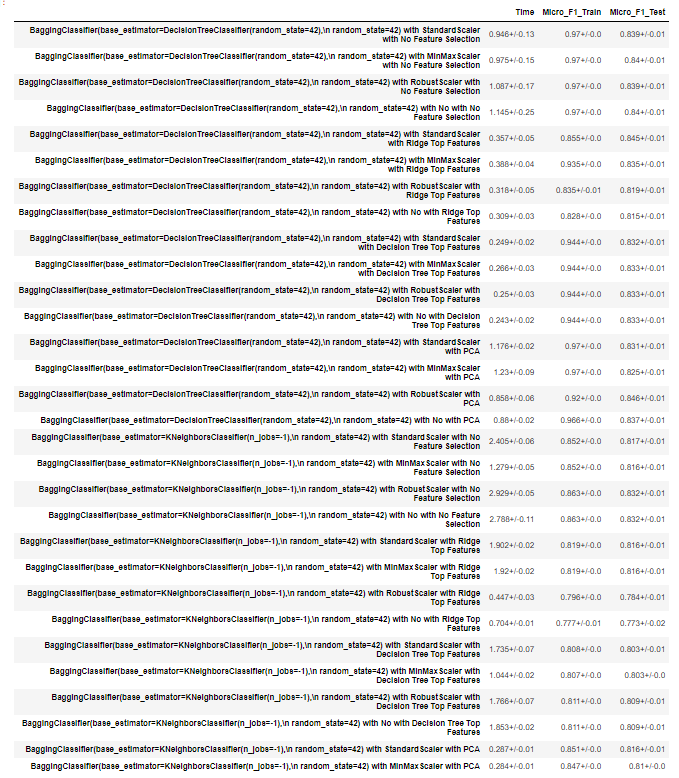

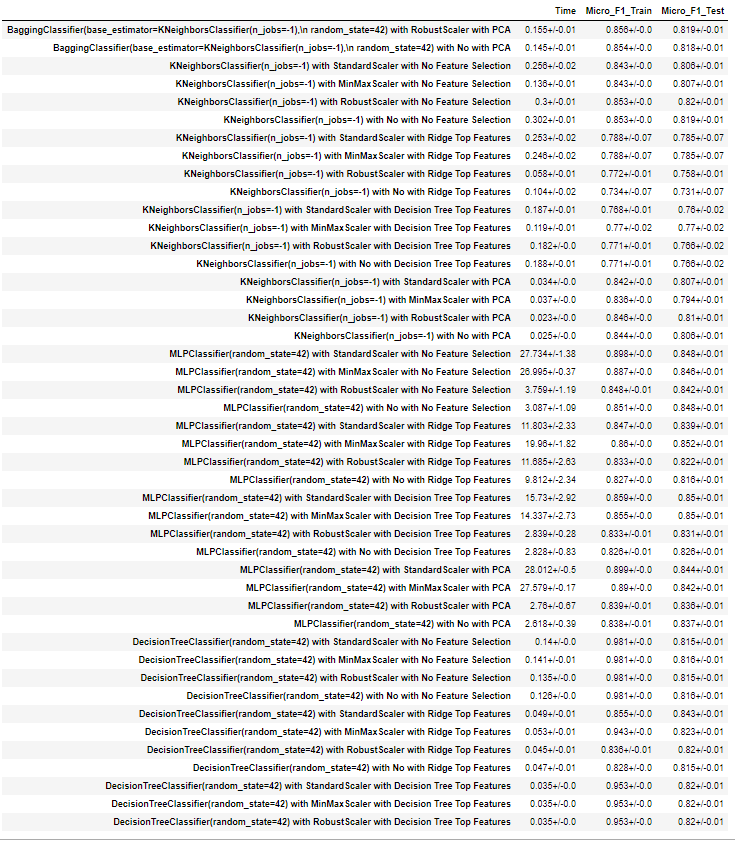

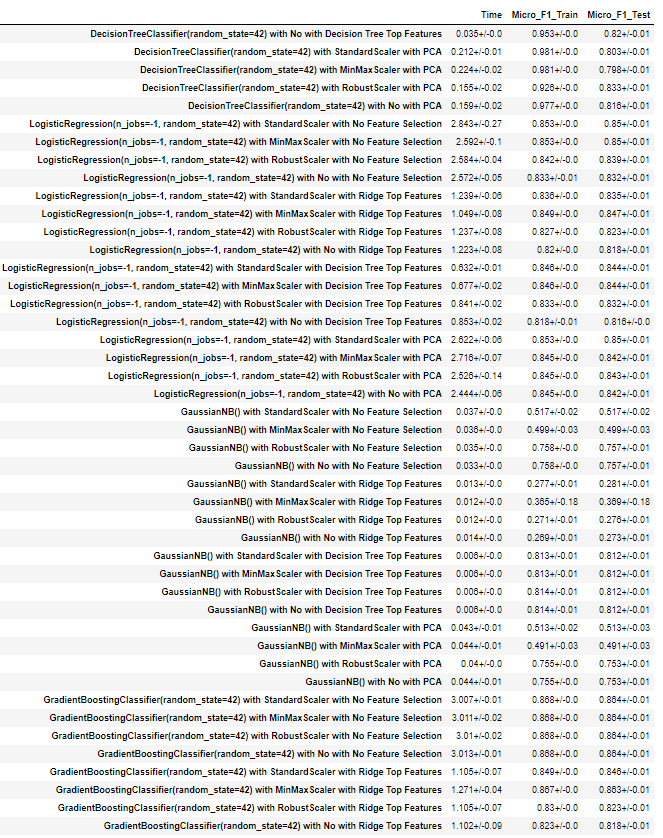

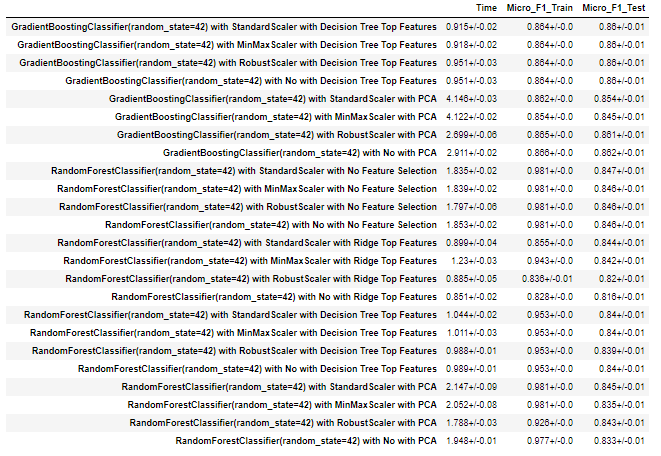


<b> Attempting with Voting Classifier

In [ ]:
# #Defining the models we will use

# RF = RandomForestClassifier(random_state= 42, n_jobs=-1)
# GB = GradientBoostingClassifier(random_state= 42)
# MLP = MLPClassifier(random_state = 42)
# LogR = LogisticRegression(random_state = 42, n_jobs=-1)

# clf1 = VotingClassifier(n_jobs=-1, -voting ="soft", estimators=[('mlp', MLP),  ('gb', GB), ("rf", RF), ("log", LogR)])
# clf2 = VotingClassifier(n_jobs=-1, voting ="hard", estimators=[('mlp', MLP),  ('gb', GB), ("rf", RF), ("log", LogR)])

# df = pd.DataFrame(columns =['Time','Micro_F1_Train','Micro_F1_Test'])

# #Defining the estimators and scalers we will use
# estimators = [ "No Feature Selection", "Ridge Top Features","Decision Tree Top Features",  "PCA"]
# scalers = [StandardScaler(), MinMaxScaler(), RobustScaler(), "None"]

# #creating a list with the models to be tested
# models = [clf1, clf2]

# #iterating by the model, by the estimator and by the scaler method and calling the function show_results for each one
# for model in models:
#     for estimator in estimators:
#          for scale in  scalers:
#             show_results(df, scale, estimator, model)

In [ ]:
# df

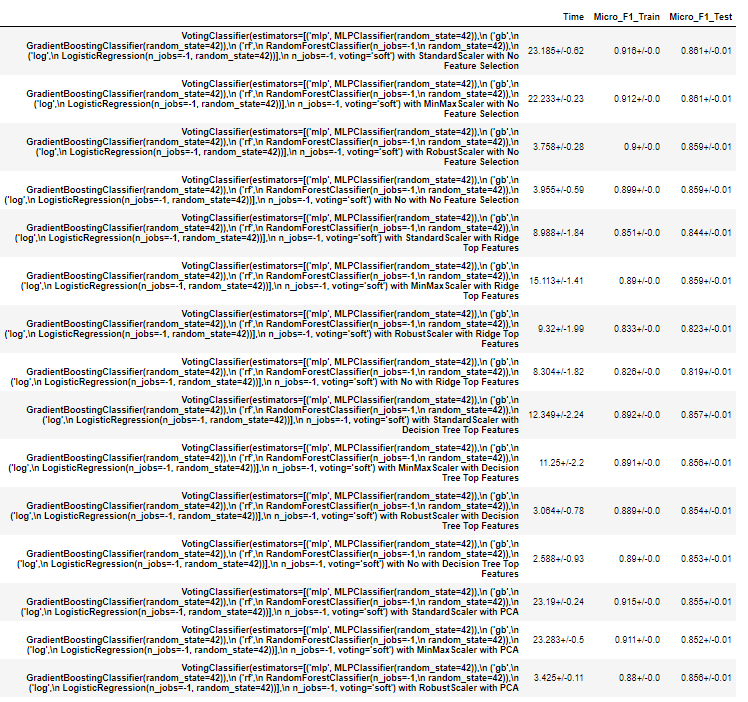

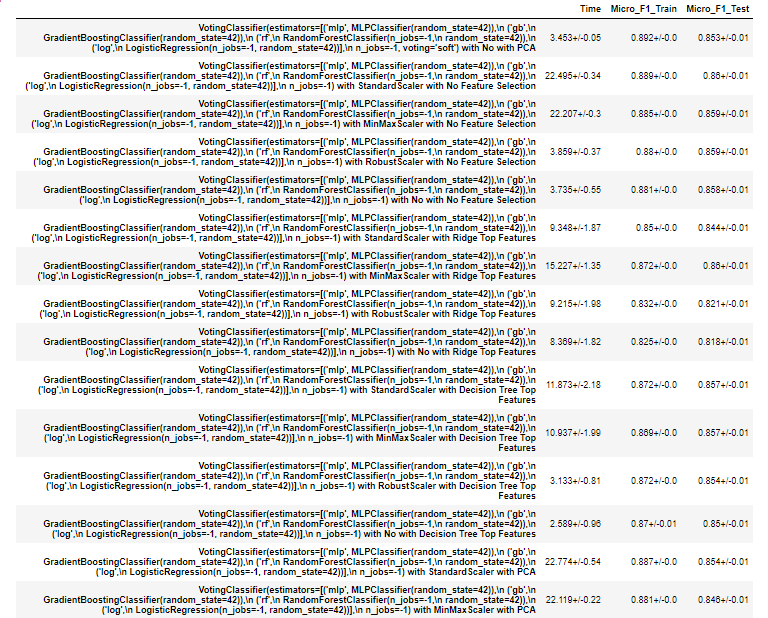

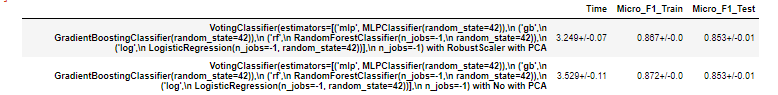

<b> Now, with the 3 best models (except Logistic Regression, as it is not as customizable as the remaining), we will attempt to improve them with paramters tunning.

In [ ]:
# #We will not comment here, as basically all techniques here descibed were already commented above
# def avg_score(model):
#     '''This function will accept a model, and, using a Stratified KFold and some data preparation techniques, return the average performance, standard deviation of the model and time the model took to run.'''

#     global data, target
    
    
#     kf = StratifiedKFold(n_splits=10, shuffle= True, random_state=42) 

#     score_train= []
#     score_test= []
#     timer = []
    
#     for train_index, test_index in kf.split(data, target):
        
#         X_train, X_test = data.iloc[train_index], data.iloc[test_index]
#         y_train, y_test = target.iloc[train_index], target.iloc[test_index]
        
#         X_train = X_train[(X_train["Age"]>=17) & (X_train["Age"]<=90) & (X_train["Working Hours per week"]>=0) & (X_train["Working Hours per week"]<=80) & (X_train["Ticket Price"]<=3000) & (X_train["Money Received"]<40000) & (X_train["Years of Education"]<=21) & (X_train["Years of Education"]>=2)]
#         y_train=y_train.loc[X_train.index.values]
        
#         X_train["Employment Sector"] = X_train["Employment Sector"].fillna(X_train["Employment Sector"].mode()[0])
#         X_train["Role"] = X_train["Role"].fillna(X_train["Role"].mode()[0])
#         X_train["Base Area"] = X_train["Base Area"].fillna(X_train["Base Area"].mode()[0])
        
#         X_test["Employment Sector"] = X_test["Employment Sector"].fillna(X_train["Employment Sector"].mode()[0])
#         X_test["Role"] = X_test["Role"].fillna(X_train["Role"].mode()[0])
#         X_test["Base Area"] = X_test["Base Area"].fillna(X_train["Base Area"].mode()[0])
        
                
#         X_dummy_model = pd.concat([X_train, X_test])
#         encoder = OneHotEncoder(sparse=False, drop="first")
#         encoder.fit(X_dummy_model[categorical_features])

#         x = encoder.transform(X_train[categorical_features])
#         x = pd.DataFrame(x, index=X_train.index, columns = encoder.get_feature_names(categorical_features))
#         X_train = pd.concat([X_train.drop(columns =categorical_features),x], axis=1)

#         x = encoder.transform(X_test[categorical_features])
#         x = pd.DataFrame(x, index=X_test.index, columns = encoder.get_feature_names(categorical_features))
#         X_test = pd.concat([X_test.drop(columns =categorical_features),x], axis=1) 

#         #If the model passed regards MLP, we will use the scaler method Min-Max
#         #Note that we will fit our scaler to the X_train, but then we will transform the X_train and the X_test based on that unique fit.
#         #Then, we will use the RidgeClassifier as selector.
#         #Once more, the selector is fit to the X_train, and then both X_train and X_test are changed based on that fit.
#         if ("MLP" in str(model)):
    
#             scaler = MinMaxScaler().fit(X_train[numeric_features])
#             X_train[numeric_features]=scaler.transform(X_train[numeric_features])
#             X_test[numeric_features]=scaler.transform(X_test[numeric_features])
            
#             selector = SelectFromModel(estimator = RidgeClassifier(random_state= 42))
#             selector.fit(X_train, y_train)
#             X_train = X_train[X_train.columns[(selector.get_support())]]
#             X_test = X_test[X_test.columns[(selector.get_support())]]

#         #If the model passed is a Random Forest, therefore, contains the letters "RF", we will use a Sandard Scaler.
#         #Note that the scaler is fit to the X_train, and then both X_train and X_test are transformed based on it.
#         elif ("RF" in str(model)):
    
#             scaler = StandardScaler().fit(X_train[numeric_features])
#             X_train[numeric_features]=scaler.transform(X_train[numeric_features])
#             X_test[numeric_features]=scaler.transform(X_test[numeric_features])


#         begin = time.perf_counter()
#         model.fit(X_train, y_train)
#         end = time.perf_counter()

#         value_train = f1_score(y_train, model.predict(X_train), average="micro")
#         value_test = f1_score(y_test, model.predict(X_test), average="micro")
            
        
#         score_train.append(value_train)
#         score_test.append(value_test)
#         timer.append(end-begin)
        
#     avg_time = round(np.mean(timer),3)    
#     avg_train = round(np.mean(score_train),3)
#     avg_test = round(np.mean(score_test),3)
#     std_time = round(np.std(timer),2)   
#     std_train = round(np.std(score_train),2)
#     std_test = round(np.std(score_test),2)
    

#     return str(avg_time) + '+/-' + str(std_time), str(avg_train) + '+/-' + str(std_train), str(avg_test) + '+/-' + str(std_test)


# def show_results(df, arg):
#     '''This function takes as input an empty dataframe and a model, and by calling the function avg_score, will store in the dataframe the indicators received from this function.'''
#     time, avg_train, avg_test = avg_score(arg)

#     df.loc[str(arg)] = time, avg_train, avg_test
#     return df

In [ ]:
# #Creating our GradientBoosting models

# GB1 = GradientBoostingClassifier(n_estimators=1000, max_features="sqrt", min_samples_leaf=3, random_state= 42)
# GB2 = GradientBoostingClassifier(n_estimators=1000, max_features=0.35, min_samples_leaf=3, random_state= 42)
# GB3 = GradientBoostingClassifier(n_estimators=1000, max_features=None, min_samples_leaf=3, random_state= 42)

# GB4 = GradientBoostingClassifier(n_estimators=1250, max_features="sqrt", min_samples_leaf=3, random_state= 42)
# GB5 = GradientBoostingClassifier(n_estimators=1250, max_features=0.35, min_samples_leaf=3, random_state= 42)
# GB6  = GradientBoostingClassifier(n_estimators=1250, max_features=None, min_samples_leaf=3, random_state= 42)

# GB7  = GradientBoostingClassifier(n_estimators=1150, max_features="sqrt", min_samples_leaf=3, random_state= 42)
# GB8 = GradientBoostingClassifier(n_estimators=1150, max_features=0.35, min_samples_leaf=3, random_state= 42)
# GB9 = GradientBoostingClassifier(n_estimators=1150, max_features=None, min_samples_leaf=3, random_state= 42)

# GB10 = GradientBoostingClassifier(n_estimators=1000, max_features="sqrt", min_samples_leaf=2, random_state= 42)
# GB11 = GradientBoostingClassifier(n_estimators=1000, max_features=0.35, min_samples_leaf=2, random_state= 42)
# GB12 = GradientBoostingClassifier(n_estimators=1000, max_features=None,min_samples_leaf=2, random_state= 42)

# GB13 = GradientBoostingClassifier(n_estimators=1250, max_features="sqrt", min_samples_leaf=2, random_state= 42)
# GB14 = GradientBoostingClassifier(n_estimators=1250, max_features=0.35, min_samples_leaf=2, random_state= 42)
# GB15 = GradientBoostingClassifier(n_estimators=1250, max_features=None,min_samples_leaf=2, random_state= 42)

# GB16 = GradientBoostingClassifier(n_estimators=1150, max_features="sqrt", min_samples_leaf=2, random_state= 42)
# GB17 = GradientBoostingClassifier(n_estimators=1150, max_features=0.35, min_samples_leaf=2, random_state= 42)
# GB18 = GradientBoostingClassifier(n_estimators=1150, max_features=None, min_samples_leaf=2, random_state= 42)

# models = (GB1,GB2,GB3,GB4,GB5,GB6,GB7,GB8,GB9,GB10,GB11,GB12,GB13,GB14,GB15,GB16,GB17,GB18)

# df = pd.DataFrame(columns =['Time','Micro_F1_Train','Micro_F1_Test'])

# for model in models:
#     show_results(df, model)

In [ ]:
# #Getting our results
# gbd = df.copy()
# gbd

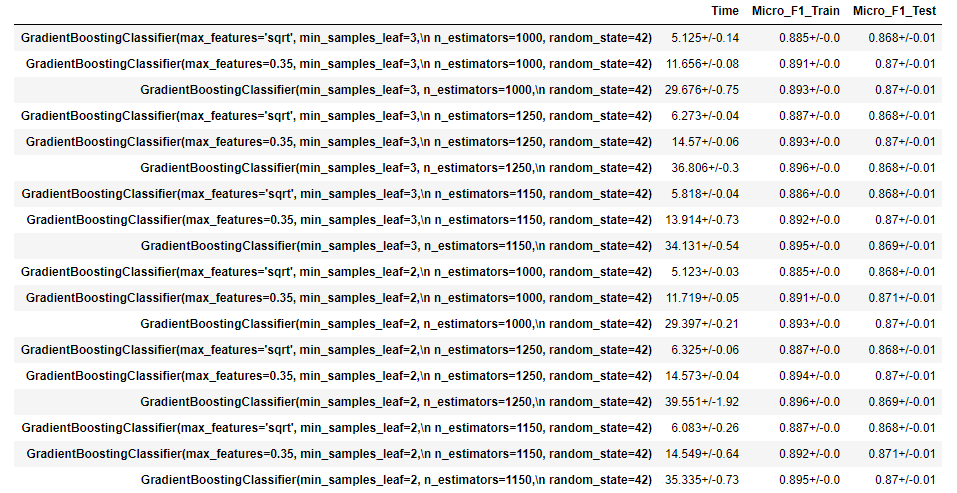

In [ ]:
# #Creating our MLP models

# MLP1 = MLPClassifier(hidden_layer_sizes = (75,75),activation = 'relu', solver = 'adam',  random_state = 42,max_iter = 350)
# MLP2 = MLPClassifier(hidden_layer_sizes = (75,100,75), activation = 'relu', solver = 'adam', random_state = 42,max_iter = 350)
# MLP3 = MLPClassifier(hidden_layer_sizes = (100,), activation = 'relu', solver = 'adam', random_state = 42,max_iter = 350)


# MLP4 = MLPClassifier(hidden_layer_sizes = (75,75),activation = 'tanh', solver = 'adam', random_state = 42,max_iter = 350)
# MLP5 = MLPClassifier(hidden_layer_sizes = (75,100,75), activation = 'tanh', solver = 'adam', random_state = 42,max_iter = 350)
# MLP6 = MLPClassifier(hidden_layer_sizes = (100,), activation = 'tanh', solver = 'adam', random_state = 42,max_iter = 350)


# MLP7 = MLPClassifier(hidden_layer_sizes = (75,75),activation = 'relu', solver = 'sgd', random_state = 42,max_iter = 350)
# MLP8 = MLPClassifier(hidden_layer_sizes = (75,100,75), activation = 'relu', solver = 'sgd', random_state = 42,max_iter = 350)
# MLP9 = MLPClassifier(hidden_layer_sizes = (100,), activation = 'relu', solver = 'sgd', random_state = 42,max_iter = 350)


# MLP10 = MLPClassifier(hidden_layer_sizes = (75,75),activation = 'tanh',  solver = 'sgd', random_state = 42,max_iter = 350)
# MLP11= MLPClassifier(hidden_layer_sizes = (75,100,75), activation = 'tanh', solver = 'sgd', random_state = 42,max_iter = 350)
# MLP12 = MLPClassifier(hidden_layer_sizes = (100,), activation = 'tanh', solver = 'sgd', random_state = 42,max_iter = 350)


# MLP13 = MLPClassifier(hidden_layer_sizes = (75,75), activation = 'relu', solver = 'sgd', learning_rate = 'invscaling' , random_state = 42,max_iter = 350)
# MLP14 = MLPClassifier(hidden_layer_sizes = (75,100,75), activation = 'relu', solver = 'sgd',learning_rate = 'invscaling' , random_state = 42,max_iter = 350)
# MLP15 = MLPClassifier(hidden_layer_sizes = (100,), activation = 'relu', solver = 'sgd',learning_rate = 'invscaling' , random_state = 42,max_iter = 350)


# MLP16 = MLPClassifier(hidden_layer_sizes = (75,75),activation = 'tanh',  solver = 'sgd', learning_rate = 'invscaling', random_state = 42, max_iter = 350)
# MLP17 = MLPClassifier(hidden_layer_sizes = (75,100,75), activation = 'tanh', solver = 'sgd',learning_rate = 'invscaling', random_state = 42, max_iter = 350)
# MLP18 = MLPClassifier(hidden_layer_sizes = (100,), activation = 'tanh', solver = 'sgd',learning_rate = 'invscaling', random_state = 42, max_iter = 350)


# MLP19 = MLPClassifier(hidden_layer_sizes = (75,75),activation = 'relu', solver = 'adam',  random_state = 42,max_iter = 350, learning_rate_init = 0.0001)
# MLP20 = MLPClassifier(hidden_layer_sizes = (75,100,75), activation = 'relu', solver = 'adam', random_state = 42,max_iter = 350, learning_rate_init = 0.0001)
# MLP21 = MLPClassifier(hidden_layer_sizes = (100,), activation = 'relu', solver = 'adam', random_state = 42,max_iter = 350, learning_rate_init = 0.0001)


# MLP22 = MLPClassifier(hidden_layer_sizes = (75,75),activation = 'tanh', solver = 'adam', random_state = 42,max_iter = 350, learning_rate_init = 0.0001)
# MLP23 = MLPClassifier(hidden_layer_sizes = (75,100,75), activation = 'tanh', solver = 'adam', random_state = 42,max_iter = 350, learning_rate_init = 0.0001)
# MLP24 = MLPClassifier(hidden_layer_sizes = (100,), activation = 'tanh', solver = 'adam', random_state = 42,max_iter = 350, learning_rate_init = 0.0001)


# MLP25 = MLPClassifier(hidden_layer_sizes = (75,75),activation = 'relu', solver = 'sgd', random_state = 42,max_iter = 350, learning_rate_init = 0.0001)
# MLP26 = MLPClassifier(hidden_layer_sizes = (75,100,75), activation = 'relu', solver = 'sgd', random_state = 42,max_iter = 350, learning_rate_init = 0.0001)
# MLP27 = MLPClassifier(hidden_layer_sizes = (100,), activation = 'relu', solver = 'sgd', random_state = 42,max_iter = 350, learning_rate_init = 0.0001)


# MLP28 = MLPClassifier(hidden_layer_sizes = (75,75),activation = 'tanh',  solver = 'sgd', random_state = 42,max_iter = 350, learning_rate_init = 0.0001)
# MLP29 = MLPClassifier(hidden_layer_sizes = (75,100,75), activation = 'tanh', solver = 'sgd', random_state = 42,max_iter = 350, learning_rate_init = 0.0001)
# MLP30 = MLPClassifier(hidden_layer_sizes = (100,), activation = 'tanh', solver = 'sgd', random_state = 42,max_iter = 350, learning_rate_init = 0.0001)

# models = (MLP1,MLP2,MLP3,MLP4,MLP5,MLP6,MLP7,MLP8,MLP9,MLP10,MLP11,MLP12,MLP13,MLP14,MLP15,MLP16,MLP17,MLP18,MLP19,MLP20,MLP21,MLP22,MLP23, MLP24, MLP25, MLP26, MLP27, MLP28, MLP29, MLP30)

# df = pd.DataFrame(columns =['Time','Micro_F1_Train','Micro_F1_Test'])

# for model in models:
#     show_results(df, model)

In [ ]:
# #Getting the results.
# mlpd =df.copy()
# mlpd

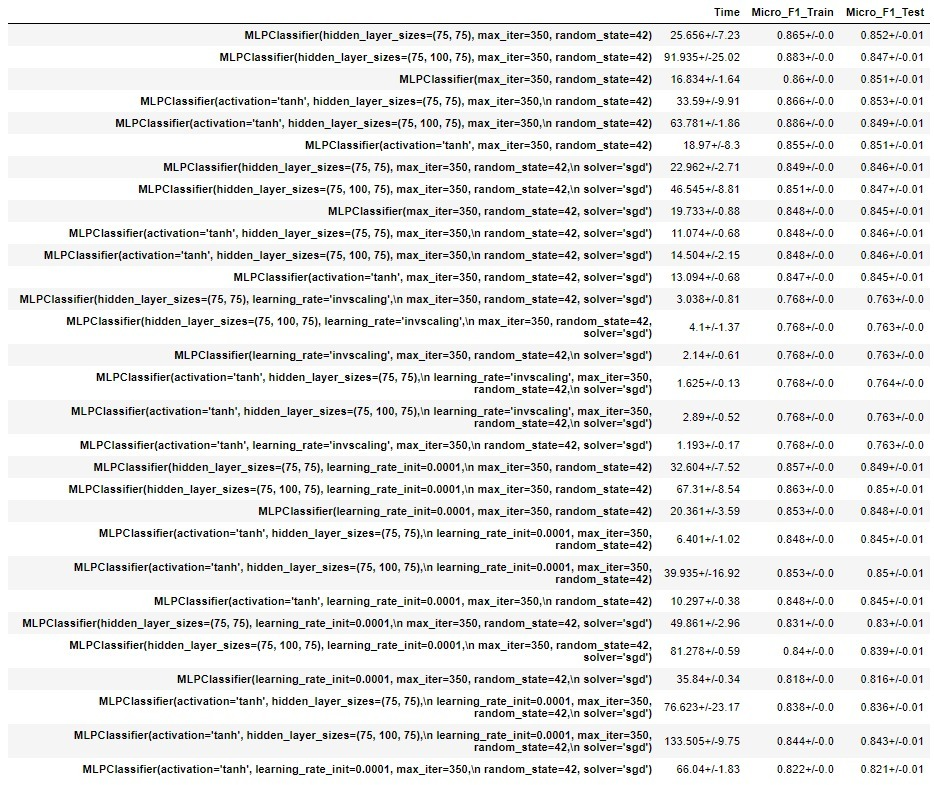

In [ ]:
# #Creating our Random Forest models.

# RF1 = RandomForestClassifier(n_estimators=500, max_features="sqrt", min_samples_leaf=3, random_state= 42, n_jobs=-1)
# RF2 = RandomForestClassifier(n_estimators=500, max_features=0.35, min_samples_leaf=3, random_state= 42, n_jobs=-1)
# RF3 = RandomForestClassifier(n_estimators=500, max_features=None, min_samples_leaf=3, random_state= 42, n_jobs=-1)

# RF4 = RandomForestClassifier(n_estimators=1250, max_features="sqrt", min_samples_leaf=3, random_state= 42, n_jobs=-1)
# RF5 = RandomForestClassifier(n_estimators=1250, max_features=0.35, min_samples_leaf=3, random_state= 42, n_jobs=-1)
# RF6  = RandomForestClassifier(n_estimators=1250, max_features=None, min_samples_leaf=3, random_state= 42, n_jobs=-1)

# RF7  = RandomForestClassifier(n_estimators=1750, max_features="sqrt", min_samples_leaf=3, random_state= 42, n_jobs=-1)
# RF8 = RandomForestClassifier(n_estimators=1750, max_features=0.35, min_samples_leaf=3, random_state= 42, n_jobs=-1)
# RF9 = RandomForestClassifier(n_estimators=1750, max_features=None, min_samples_leaf=3, random_state= 42, n_jobs=-1)

# RF10 = RandomForestClassifier(n_estimators=500, max_features="sqrt", min_samples_leaf=5, random_state= 42, n_jobs=-1)
# RF11 = RandomForestClassifier(n_estimators=500, max_features=0.35, min_samples_leaf=5, random_state= 42, n_jobs=-1)
# RF12 = RandomForestClassifier(n_estimators=500, max_features=None,min_samples_leaf=5, random_state= 42, n_jobs=-1)

# RF13 = RandomForestClassifier(n_estimators=1250, max_features="sqrt", min_samples_leaf=5, random_state= 42, n_jobs=-1)
# RF14 = RandomForestClassifier(n_estimators=1250, max_features=0.35, min_samples_leaf=5, random_state= 42, n_jobs=-1)
# RF15 = RandomForestClassifier(n_estimators=1250, max_features=None,min_samples_leaf=5, random_state= 42, n_jobs=-1)

# RF16 = RandomForestClassifier(n_estimators=1750, max_features="sqrt", min_samples_leaf=5, random_state= 42, n_jobs=-1)
# RF17 = RandomForestClassifier(n_estimators=1750, max_features=0.35, min_samples_leaf=5, random_state= 42, n_jobs=-1)
# RF18 = RandomForestClassifier(n_estimators=1750, max_features=None, min_samples_leaf=5, random_state= 42, n_jobs=-1)

# models = (RF1,RF2,RF3,RF4,RF5,RF6,RF7,RF8,RF9,RF10,RF11,RF12,RF13,RF14,RF15,RF16,RF17,RF18)

# df = pd.DataFrame(columns =['Time','Micro_F1_Train','Micro_F1_Test'])

# for model in models:
#     show_results(df, model)

In [ ]:
# #Getting the results.

# rfd = df.copy()
# rfd

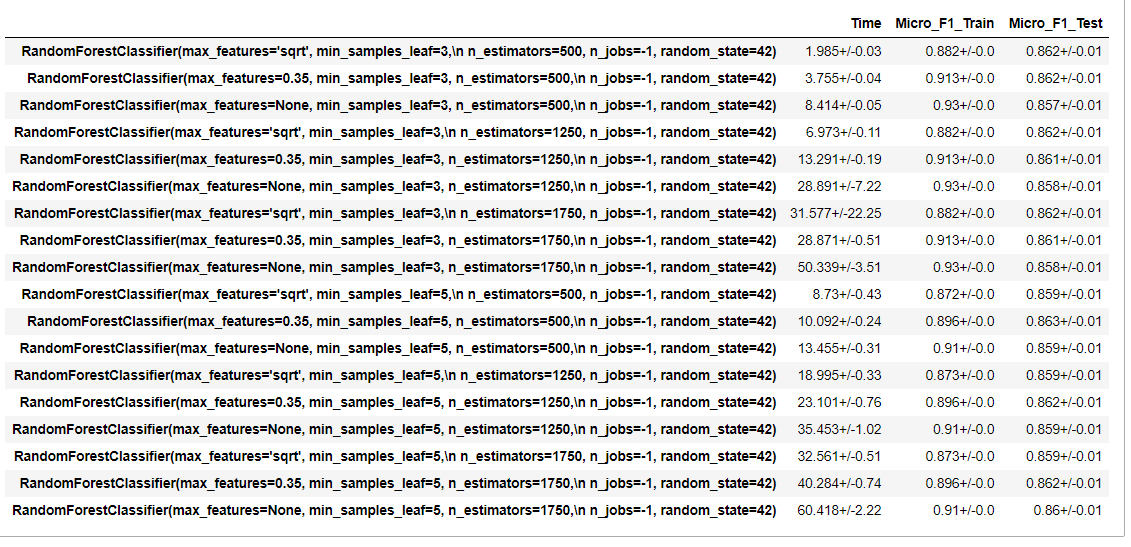

<b> Lastly, we will attempt Random Oversampling and SMOTE-NC in the best models from above (in the case of the Gradient Boosting we had a tie in test set performance, but we will keep the one with highest F1 value in the train, also, and in the case of the MLP classifier we achieved better results with no parameter tunning that with parameter tunning, so we will attempt to use the standard model).

In [ ]:
# def avg_score(oversampling, percentage, model):
#     '''This function will accept a model, a percentage and a oversampling technique to be applied before fitting the model, and, using a Stratified KFold and some data preparation techniques, return the average performance, standard deviation of the model and time the model took to run.'''

#     global data, target

#     kf = StratifiedKFold(n_splits=10, shuffle= True, random_state=42) 

#     score_train= []
#     score_test= []
#     timer = []
    
#     for train_index, test_index in kf.split(data, target):
        
#         X_train, X_test = data.iloc[train_index], data.iloc[test_index]
#         y_train, y_test = target.iloc[train_index], target.iloc[test_index]
        
#         X_train = X_train[(X_train["Age"]>=17) & (X_train["Age"]<=90) & (X_train["Working Hours per week"]>=0) & (X_train["Working Hours per week"]<=80) & (X_train["Ticket Price"]<=3000) & (X_train["Money Received"]<40000) & (X_train["Years of Education"]<=21) & (X_train["Years of Education"]>=2)]
#         y_train=y_train.loc[X_train.index.values]


#         X_train["Employment Sector"] = X_train["Employment Sector"].fillna(X_train["Employment Sector"].mode()[0])
#         X_train["Role"] = X_train["Role"].fillna(X_train["Role"].mode()[0])
#         X_train["Base Area"] = X_train["Base Area"].fillna(X_train["Base Area"].mode()[0])
        
#         X_test["Employment Sector"] = X_test["Employment Sector"].fillna(X_train["Employment Sector"].mode()[0])
#         X_test["Role"] = X_test["Role"].fillna(X_train["Role"].mode()[0])
#         X_test["Base Area"] = X_test["Base Area"].fillna(X_train["Base Area"].mode()[0])
        
        
#         #If the parameter oversampling is equal to Random_oversampling, we will aply random oversampling (with the given percentage)
#         if oversampling == "Random_oversampling":
#             oversample = RandomOverSampler(sampling_strategy= percentage, random_state=42)        
#             X_train, y_train = oversample.fit_resample(X_train, y_train)

#         #otherwise, using the same percentage we will use SMOTE-NC technique    
#         else: 
#             #Getting the indexes of our categorical variables, as we have to pass them to SMOTENC
#             indexes=[]
#             for feature in categorical_features:
#                 indexes.append(data.columns.get_loc(feature))
            
#             over = SMOTENC(random_state=42, categorical_features=indexes, sampling_strategy= percentage)
#             X_train, y_train = over.fit_resample(X_train, y_train)
          

#         X_dummy_model = pd.concat([X_train, X_test])
#         encoder = OneHotEncoder(sparse=False, drop="first")
#         encoder.fit(X_dummy_model[categorical_features])

#         x = encoder.transform(X_train[categorical_features])
#         x = pd.DataFrame(x, index=X_train.index, columns = encoder.get_feature_names(categorical_features))
#         X_train = pd.concat([X_train.drop(columns =categorical_features),x], axis=1)

#         x = encoder.transform(X_test[categorical_features])
#         x = pd.DataFrame(x, index=X_test.index, columns = encoder.get_feature_names(categorical_features))
#         X_test = pd.concat([X_test.drop(columns =categorical_features),x], axis=1) 

        
#         if ("MLP" in str(model)):
    
#             scaler = MinMaxScaler().fit(X_train[numeric_features])
#             X_train[numeric_features]=scaler.transform(X_train[numeric_features])
#             X_test[numeric_features]=scaler.transform(X_test[numeric_features])
            
#             selector = SelectFromModel(estimator = RidgeClassifier(random_state= 42))
#             selector.fit(X_train, y_train)
#             X_train = X_train[X_train.columns[(selector.get_support())]]
#             X_test = X_test[X_test.columns[(selector.get_support())]]

#         elif ("RF" in str(model)):
    
#             scaler = StandardScaler().fit(X_train[numeric_features])
#             X_train[numeric_features]=scaler.transform(X_train[numeric_features])
#             X_test[numeric_features]=scaler.transform(X_test[numeric_features])
            
#         begin = time.perf_counter()
#         model.fit(X_train, y_train)
#         end = time.perf_counter()

#         value_train = f1_score(y_train, model.predict(X_train), average="micro")
#         value_test = f1_score(y_test, model.predict(X_test), average="micro") 
            
        
#         score_train.append(value_train)
#         score_test.append(value_test)
#         timer.append(end-begin)
        
#     avg_time = round(np.mean(timer),3)    
#     avg_train = round(np.mean(score_train),3)
#     avg_test = round(np.mean(score_test),3)
#     std_time = round(np.std(timer),2)   
#     std_train = round(np.std(score_train),2)
#     std_test = round(np.std(score_test),2)
    
    
#     return str(avg_time) + '+/-' + str(std_time), str(avg_train) + '+/-' + str(std_train), str(avg_test) + '+/-' + str(std_test)


# def show_results(df, oversampling, percentage, arg):
#     '''This function takes as input an empty dataframe, an oversampling technique, a percentage and a model, and by calling the function avg_score, will store in the dataframe the indicators received from this function.'''
#     time, avg_train, avg_test = avg_score(oversampling, percentage, arg)

# #* #Same as before, but this time, we are making sure the index of the dataframe is the name of the model plus the scaler used to be easier to look at the results
#     df.loc[str(arg)+ " with " + str(percentage) +" "+str(oversampling)] = time, avg_train, avg_test
#     return df

In [ ]:
# #Defining the percentages and the oversampling techniques to be used.
# percentages =[0.35, 0.4, 0.45]
# oversamplings = ["SMOTE-NC","Random_oversampling"]

# #Defining the models to be used.
# RF = RandomForestClassifier(n_estimators=500, max_features=0.35, min_samples_leaf=5, random_state= 42, n_jobs=-1)
# GB = GradientBoostingClassifier(n_estimators=1150, max_features=0.35, min_samples_leaf=2, random_state= 42)
# MLP = MLPClassifier(random_state = 42)

# models=[RF, GB, MLP]

# df = pd.DataFrame(columns =['Time','Micro_F1_Train','Micro_F1_Test'])

# #Interating over each model, oversampling technique and percentage.
# for model in models:
#     for oversampling in oversamplings:
#         for percentage in percentages:
#             show_results(df,oversampling, percentage,  model)

In [ ]:
# #Getting the results
# df

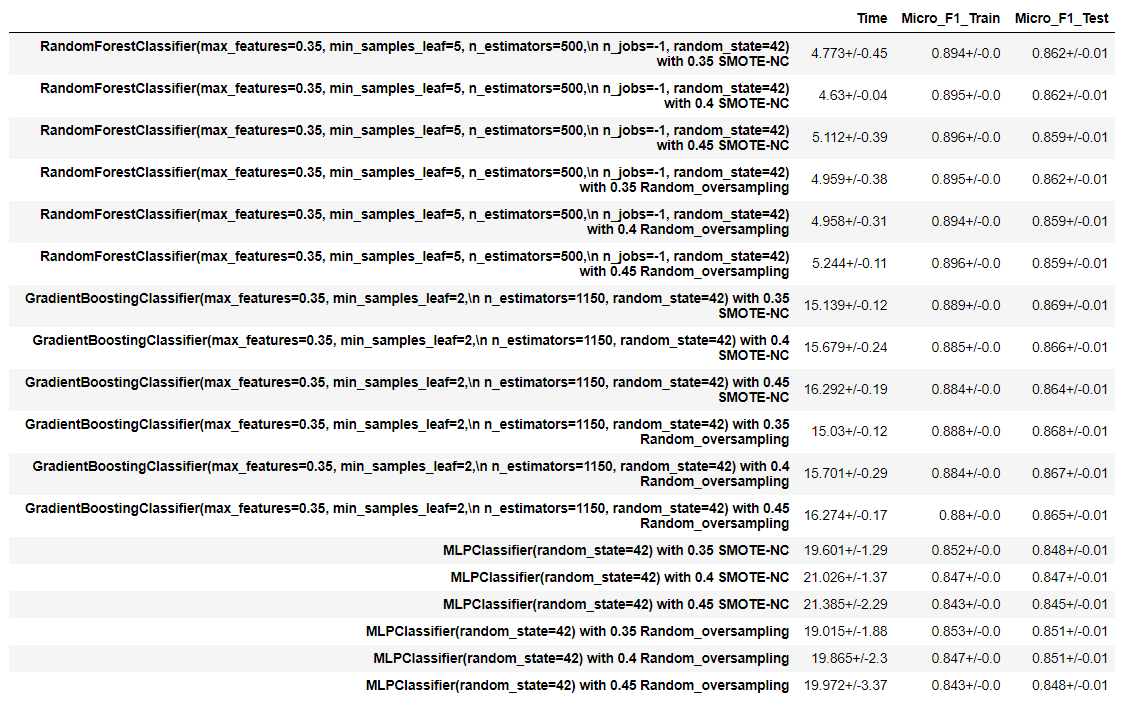

<b> Final attempt with Voting Classifier with the 3 models tunned

In [ ]:
# def avg_score(scale, estimator, model):
#     '''This function will accept a model, standarization method and a feature selector, and, using a Stratified KFold and some data preparation techniques (including the standarization of data with the method received as input), return the average performance, standard deviation of the model and time the model took to run.'''

#     global data, target, numeric_features, categorical_features
    
#     #Using kfold=10, as empirically, this is the number of folds that usually yields the best results
#     kf = StratifiedKFold(n_splits=10, shuffle= True, random_state=42) 
    
#     #Creating lists to store the results obtained in each fold
#     score_train= []
#     score_test= []
#     timer = []
    
#     #Iterating over each fold
#     for train_index, test_index in kf.split(data, target):
        
#         #Defining our X_train, X_test, y_train and y_test
#         X_train, X_test = data.iloc[train_index], data.iloc[test_index]
#         y_train, y_test = target.iloc[train_index], target.iloc[test_index]
        
#         X_train = X_train[(X_train["Age"]>=17) & (X_train["Age"]<=90) & (X_train["Working Hours per week"]>=0) & (X_train["Working Hours per week"]<=80) & (X_train["Ticket Price"]<=3000) & (X_train["Money Received"]<40000) & (X_train["Years of Education"]<=21) & (X_train["Years of Education"]>=2)]
#         y_train=y_train.loc[X_train.index.values]
        
#         X_train["Employment Sector"] = X_train["Employment Sector"].fillna(X_train["Employment Sector"].mode()[0])
#         X_train["Role"] = X_train["Role"].fillna(X_train["Role"].mode()[0])
#         X_train["Base Area"] = X_train["Base Area"].fillna(X_train["Base Area"].mode()[0])
        
        
#         X_test["Employment Sector"] = X_test["Employment Sector"].fillna(X_train["Employment Sector"].mode()[0])
#         X_test["Role"] = X_test["Role"].fillna(X_train["Role"].mode()[0])
#         X_test["Base Area"] = X_test["Base Area"].fillna(X_train["Base Area"].mode()[0])
        
       
#         #Using the too_strong_corr function (with a threshold of 0.75) to get the redundant numeric features in X_train, in order to drop them in both the X_train and the X_test
#         corr = too_strong_corr(X_train[numeric_features], 0.75)    
#         if len(corr)!=0:
#             X_train.drop(corr, axis=1, inplace=True)
#             X_test.drop(corr, axis=1, inplace=True)
#             for column in corr:
#                 numeric_features.remove(column)

#         #Using the function mutual_information (with a threshold of 0.75), to get the redundant categorical features in X_train, so we can drop them in both the X_train and the X_test
#         mutual = mutual_information(X_train, categorical_features, 0.75)    
#         if len (mutual)!=0:
#             X_train.drop(mutual , axis=1, inplace=True)
#             X_test.drop(mutual, axis=1, inplace=True)
#             for column in mutual:
#                 categorical_features.remove(column)

#         #If the scale method given to the function is "None", this means there is no scale method, and therefore, we will just proceed
#         if scale == "None":
#             scale = "None"

#         #Otherwise, if a scale method is given, we will fit it to the X_train, so then we can transform both the X_train and the X_test, without incurring in data leakage
#         else:
#             scaler = scale.fit(X_train[numeric_features])
#             X_train[numeric_features]=scaler.transform(X_train[numeric_features])
#             X_test[numeric_features]=scaler.transform(X_test[numeric_features])
        
#         X_dummy_model = pd.concat([X_train, X_test])
#         encoder = OneHotEncoder(sparse=False, drop="first")
#         encoder.fit(X_dummy_model[categorical_features])

#         x = encoder.transform(X_train[categorical_features])
#         x = pd.DataFrame(x, index=X_train.index, columns = encoder.get_feature_names(categorical_features))
#         X_train = pd.concat([X_train.drop(columns =categorical_features),x], axis=1)

#         x = encoder.transform(X_test[categorical_features])
#         x = pd.DataFrame(x, index=X_test.index, columns = encoder.get_feature_names(categorical_features))
#         X_test = pd.concat([X_test.drop(columns =categorical_features),x], axis=1) 
        
       
#         #If the estimator passed is regarding Ridge (and the model does not concern the KNN), we will use RidgeClassifier to perform feature selection. 
#         #Note that we fit our selector to the X_train (and y_train), and then we use its results to withdraw the same variables from x_train and X_test
#         if ((estimator== "Ridge Top Features") and (model!=modelKNN) and (model != modelBKNN)):
#             selector = SelectFromModel(estimator = RidgeClassifier(random_state= 42))
#             selector.fit(X_train, y_train)
#             X_train = X_train[X_train.columns[(selector.get_support())]]
#             X_test = X_test[X_test.columns[(selector.get_support())]]
            
#         #If the estimator passed is regarding the Decision Tree (and the model does not concern the KNN), we will use a DecisionTreeClassifier to perform feature selection
#         #Note that we fit our selector to X_train (and y_train) in order to get the features to keep, but then we apply those results to both the X_train and the X_test
#         elif ((estimator == "Decision Tree Top Features") and (model!=modelKNN) and (model != modelBKNN)):
#             selector = SelectFromModel(estimator = DecisionTreeClassifier(random_state = 42))
#             selector.fit(X_train, y_train)
#             X_train = X_train[X_train.columns[(selector.get_support())]]
#             X_test = X_test[X_test.columns[(selector.get_support())]]
           
#         #If the estimator passed is regarding PCA, we will use it to reduce our input space.
#         #Note that here there's no problem if the model passed is the KNN, as both it and PCA only work with numeric features.
#         elif estimator =="PCA":
#             #We will create the PCA instance in order to keep the components necessary to capture 80% of the varaince of our numeric variables
#             pca = PCA(n_components=0.8, random_state=42)
#             #We will fit our 'pca' to the numeric features of our X_train, but then we will transform both our X_train and X_test with those results
#             pca_fitted= pca.fit(X_train[numeric_features])
#             pca_train= pca.transform(X_train[numeric_features])
#             pca_test= pca.transform(X_test[numeric_features])
#             pcas=[]
            
#             #Creating the names of our new variables, in the format "PCA X"
#             for num in range(1,pca.n_components_+1):
#                 pcas.append("PCA "+str(num))
            
#             #Creating a dataframe with our new variables (the PCAs) for both the X_train and the X_test
#             pcas_dataframe_train= pd.DataFrame(pca_train, columns=pcas, index=X_train.index)
#             pcas_dataframe_test= pd.DataFrame(pca_test, columns=pcas, index=X_test.index)
            
#             #Replacing our numeric features by our PCAs, for both the X_train and the X_test
#             X_train= pd.concat([X_train[encoder.get_feature_names(categorical_features)],pcas_dataframe_train], axis=1, sort=False)
#             X_test= pd.concat([X_test[encoder.get_feature_names(categorical_features)],pcas_dataframe_test], axis=1, sort=False)
        
      
#         #If the model passed is the KNN, we have to take into consideration that this model only makes sense to use with the numeric features (even if the categorical ones are encoded, as it computes the distances between observations, it makes no sense to fit them to our model)    
#         if ((model == modelKNN) or (model == modelBKNN)):
           
#             #If the estimator passed is "PCA", instead of the numeric features, we have to use our new variables, stored in list pcas
#             if estimator =="PCA":
#                 begin = time.perf_counter()
#                 model.fit(X_train[pcas], y_train)
#                 end = time.perf_counter()
            
#                 value_train = f1_score(y_train, model.predict(X_train[pcas]), average="micro")
#                 value_test = f1_score(y_test, model.predict(X_test[pcas]), average="micro")
            
#             #If we are dealing with the selection methdod Ridge Top Features, we have to take into consideration that we can only pass to Ridge the numeric features.
#             #Once again, note that we fit to our selector our X_train, and then transform both our X_train and X_test based on that fit
#             elif (estimator== "Ridge Top Features"):

#                 selector = SelectFromModel(estimator = RidgeClassifier(random_state= 42))
#                 selector.fit(X_train[numeric_features], y_train)
                
#                 X_train = X_train[X_train[numeric_features].columns[(selector.get_support())]]
#                 X_test = X_test[X_test[numeric_features].columns[(selector.get_support())]]
#                 begin = time.perf_counter()
#                 model.fit(X_train, y_train)
#                 end = time.perf_counter()
    
#                 value_train = f1_score(y_train, model.predict(X_train), average="micro")
#                 value_test = f1_score(y_test, model.predict(X_test), average="micro")
            
#             #If we are dealing with the selection methdod Decision Tree Top Features, we have to take into consideration that we can only pass to it the numeric features.
#             #Note that the selector is fit to the X_train, but then both the X_train and the X_test are transformed based on that fit.
#             elif (estimator == "Decision Tree Top Features"):
               
#                 selector = SelectFromModel(estimator = DecisionTreeClassifier(random_state = 42))
#                 selector.fit(X_train[numeric_features], y_train)
#                 X_train = X_train[X_train[numeric_features].columns[(selector.get_support())]]
#                 X_test = X_test[X_test[numeric_features].columns[(selector.get_support())]]  
            
#                 begin = time.perf_counter()
#                 model.fit(X_train, y_train)
#                 end = time.perf_counter()
    
#                 value_train = f1_score(y_train, model.predict(X_train), average="micro")
#                 value_test = f1_score(y_test, model.predict(X_test), average="micro")

#             #Otherwise, there's no need for a selector.
#             else:
                            
#                 begin = time.perf_counter()
#                 model.fit(X_train[numeric_features], y_train)
#                 end = time.perf_counter()
    
#                 value_train = f1_score(y_train, model.predict(X_train[numeric_features]), average="micro")
#                 value_test = f1_score(y_test, model.predict(X_test[numeric_features]), average="micro")

#         #If the model passed does not concern KNN.
#         else:
#             begin = time.perf_counter()
#             model.fit(X_train, y_train)
#             end = time.perf_counter()

#             value_train = f1_score(y_train, model.predict(X_train), average="micro")
#             value_test = f1_score(y_test, model.predict(X_test), average="micro")
            
#         #Appending the results each time to the lists we created in the beggining
#         score_train.append(value_train)
#         score_test.append(value_test)
#         timer.append(end-begin)
    
#     #Computing the average and standard deviation of the lists    
#     avg_time = round(np.mean(timer),3)    
#     avg_train = round(np.mean(score_train),3)
#     avg_test = round(np.mean(score_test),3)
#     std_time = round(np.std(timer),2)   
#     std_train = round(np.std(score_train),2)
#     std_test = round(np.std(score_test),2)
    

#     return str(avg_time) + '+/-' + str(std_time), str(avg_train) + '+/-' + str(std_train), str(avg_test) + '+/-' + str(std_test)


# def show_results(df,scale, estimator, arg):
#     '''This function takes as input an empty dataframe, a model and a standarization method, and by calling the function avg_score, will store in the dataframe the indicators received from this function.'''
#     time, avg_train, avg_test = avg_score(scale, estimator, arg)
# #* #Same as before, but this time, we are making sure the index of the dataframe is the name of the mode plus the scaler used to be easier to look at the results
#     df.loc[str(arg)+ " with "+str(scale)[:-2] + " with " + str(estimator)] = time, avg_train, avg_test
#     return df

In [ ]:
# #Defining the models we will use

# RF = RandomForestClassifier(n_estimators=500, max_features=0.35, min_samples_leaf=5, random_state= 42, n_jobs=-1)
# GB = GradientBoostingClassifier(n_estimators=1150, max_features=0.35, min_samples_leaf=2, random_state= 42)
# MLP = MLPClassifier(random_state = 42)

# clf1 = VotingClassifier(n_jobs=-1, voting ="soft", estimators=[('mlp', MLP),  ('gb', GB), ("rf", RF)])
# clf2 = VotingClassifier(n_jobs=-1, voting ="hard", estimators=[('mlp', MLP),  ('gb', GB), ("rf", RF)])

# df = pd.DataFrame(columns =['Time','Micro_F1_Train','Micro_F1_Test'])

# #Defining the estimators and scalers we will use
# estimators = [ "No Feature Selection", "Ridge Top Features","Decision Tree Top Features",  "PCA"]
# scalers = [StandardScaler(), MinMaxScaler(), RobustScaler(), "None"]

# #creating a list with the models to be tested
# models = [clf1, clf2]

# #iterating by the model, by the estimator and by the scaler method and calling the function show_results for each one
# for model in models:
#     for estimator in estimators:
#          for scale in  scalers:
#             show_results(df, scale, estimator, model)

In [ ]:
# df

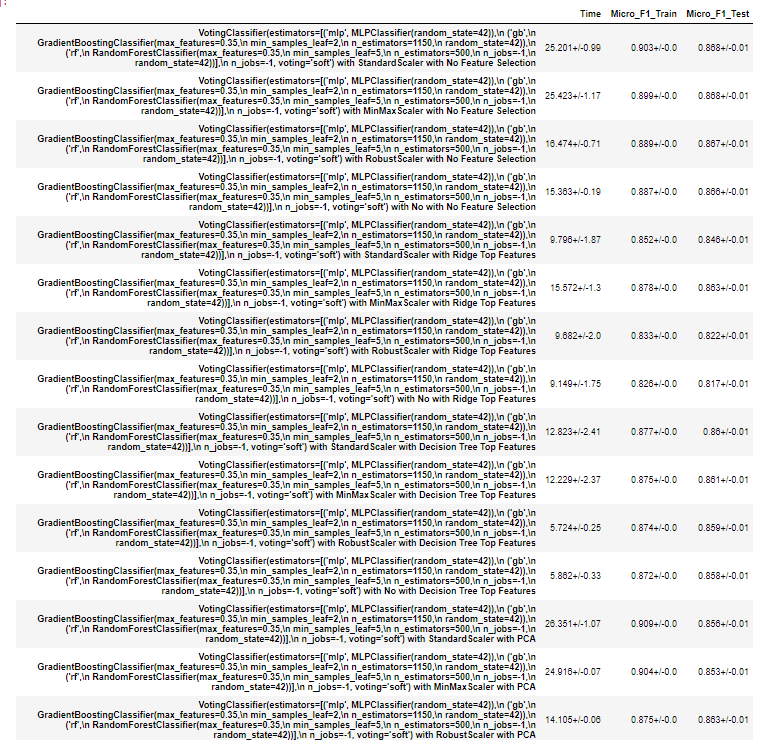

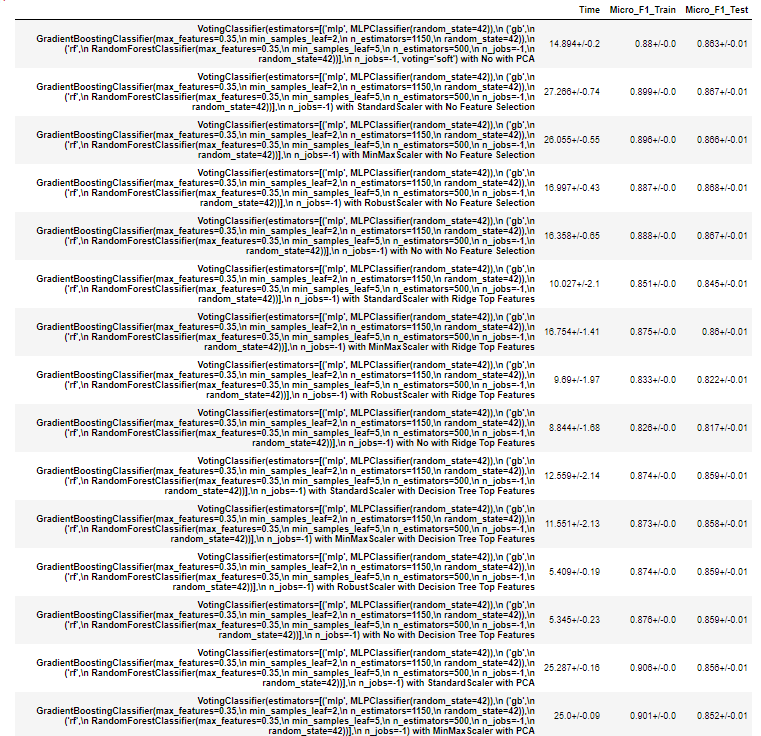


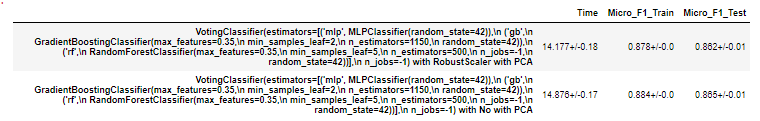